# Community Detection Using Stranger Things Dataset

## 1. Import the necessary libraries


In [1]:
import networkx as nx
import pandas as pd
import random
import itertools
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
random.seed(1)

## 2. Read the GraphML file into NetworkX library

In [3]:
graph = nx.read_graphml('StrangerThings.graphml')
nx.info(graph)

'Name: \nType: DiGraph\nNumber of nodes: 1969\nNumber of edges: 457\nAverage in degree:   0.2321\nAverage out degree:   0.2321'

## 3. Remove isolated nodes in the graph

In [4]:
def remove_isolated_nodes(G):
    print(nx.info(G))
    isolated_nodes = list(nx.isolates(G))
    print('\nIsolated nodes: {}\n'.format(len(isolated_nodes)))
    print('removing isolated nodes...\n')
    G.remove_nodes_from(isolated_nodes)
    print(nx.info(G))
    return G

graph = remove_isolated_nodes(graph)

Name: 
Type: DiGraph
Number of nodes: 1969
Number of edges: 457
Average in degree:   0.2321
Average out degree:   0.2321

Isolated nodes: 1592

removing isolated nodes...

Name: 
Type: DiGraph
Number of nodes: 377
Number of edges: 457
Average in degree:   1.2122
Average out degree:   1.2122


In [5]:
# Plot the graph
# d = dict(graph.degree)
# options = {
#     'node_color': 'red',
#     'node_size': [v * 100 for v in d.values()],
#     'line_color': 'black',
#     'linewidths': 5,
#     'font_size': 25,
#     'width': 0.5,
#     'label': 'Zachary Karate Club'
# }

# plt.rcParams['figure.figsize'] = [50, 50]
# subgraph = nx.subgraph(graph, nbunch=list(graph.nodes())[:50])
# nx.draw_networkx(subgraph, pos = nx.spring_layout(subgraph), with_labels=True, **options)

In [6]:
# Add weights to networkx graph
degree_list = ['retweet_count', 'mention_count', 'reply_count', 'quote_count']
attrs = {}
for (node1,node2,*data) in graph.edges(data=True):
    weight = sum([value for key, value in data[0].items() if key in degree_list])
    attrs[(node1, node2)] = {'weight': weight}
nx.set_edge_attributes(graph, attrs)

nx.write_graphml(graph, 'strangerthings.graphml')

## 4. Implement CD algorithms

In [7]:
# Define all community Detection Algorithms
from igraph import *

class Communities:
    
    def __init__(self, graph):
        self.G = graph
        #self.G = self.remove_self_loops(self.G)
        
    def describe(self, comms):
        print('Number of nodes: ', self.G.vcount())
        print('Number of edges: ', self.G.ecount())
        print(describe(self.G))
            
    def remove_self_loops(self, weights=None):
        # If graph has self-loops, remove the self-loops
        if not self.G.is_simple():
            self.G = self.G.simplify(loops = True, multiple = True, 
                                     combine_edges = dict(weight=weights))
        return self.G
            
    
    def convert_to_undirected(self, g, weights=None):
        # If graph is directed, convert to undirected
        #print(summary(g))
        if g.is_directed():
            g =  g.as_undirected(mode = 'collapse', combine_edges = "sum")
        return g
    
    def fast_greedy(self, weights=None):
        g = self.G.copy()
        g = self.convert_to_undirected(g)
        summary(g)
        comms = g.community_fastgreedy(weights=weights)
        print('Number of communities: ', comms.optimal_count)
        return comms
    
    def edge_betweenness(self, weights=None):
        g = self.G.copy()
        comms = g.community_edge_betweenness(clusters=None, directed=True, weights=weights)
        print('Number of communities: ', comms.optimal_count)
        return comms
    
    def infomap(self, edge_weights=None, vertex_weights=None, trials=10):
        g = self.G.copy()
        comms = g.community_infomap(edge_weights=edge_weights, vertex_weights=vertex_weights, trials=10)
        print('Number of communities: ', comms._len)
        return comms
    
    def label_propagation(self, weights=None, initial=None, fixed=None):
        g = self.G.copy()
        comms = g.community_label_propagation(weights=weights, initial=initial, fixed=fixed)
        print('Number of communities: ', comms._len)
        return comms
    
    def leading_eigen_vector(self, clusters=-1, arpack_options=None, weights=None):
        g = self.G.copy()
        g = self.convert_to_undirected(g)
        comms = g.community_leading_eigenvector(clusters=clusters, arpack_options=arpack_options, weights=weights)
        print('Number of communities: ', comms._len)
        return comms
    
    def multilevel(self, weights=None, return_levels=True):
        g = self.G.copy()
        g = self.convert_to_undirected(g)
        summary(g)
        #print(summary(g))
        comms = g.community_multilevel(weights=weights, return_levels=return_levels)
        print('Number of communities: ', len(comms))
        return comms
    
    def optimal_modularity(self, weights=None):
        g = self.G.copy()
        g = self.convert_to_undirected(g)
        print(summary(g))
        #g = self.convert_to_undirected(g)
        #print(summary(g))
        comms = g.community_optimal_modularity(weights=weights)
        print('Number of communities: ', comms._len)
        return comms
    
    def spinglass(self, weights=None, spins=25, parupdate=False, start_temp=1, stop_temp=0.01,
                  cool_fact=0.99, update_rule="simple", gamma=1, implementation="orig"):
        g = self.G.copy()
        comms = g.community_spinglass(weights=weights, spins=spins, parupdate=parupdate, start_temp=start_temp,
                                     stop_temp=stop_temp, cool_fact=cool_fact, update_rule=update_rule, gamma=gamma,
                                     implementation=implementation)
        print('Number of communities: ', comms._len)
        return comms
    
    
    def walktrap(self, weights=None, steps=4):
        g = self.G.copy()
        #g = self.convert_to_undirected(g)
        summary(g)
        comms = g.community_walktrap(weights=weights, steps=steps)
        print('Number of communities: ', comms.optimal_count)
        return comms
        
    def louvain(self):
        # TO DO: use python-louvain to implement louvain algorithm
        pass
    
    def leiden(self):
        # TO DO: use python-leidenalg to implement louvain algorithm
        pass
    
    def plot_communities(self, comms):
        visual_style = {}
        visual_style["vertex_size"] = 10
        #visual_style["vertex_label"] = graph.vs["id"]
        visual_style['edge_arrow_size'] = 0.5
        visual_style["layout"] = self.G.layout('fr')
        plot(comms, **visual_style)

## 4.1. Plot the network

In [8]:
graph = Graph.Read_GraphML('strangerthings.graphml')
community_graph = Communities(graph)
summary(graph)
visual_style = {}
visual_style["vertex_size"] = 10
#visual_style["vertex_label"] = graph.vs["id"]
visual_style['edge_arrow_size'] = 0.5
visual_style["layout"] = graph.layout('fr')
plot(graph, mark_groups=True, **visual_style)

IGRAPH D-W- 377 457 -- 
+ attr: create_time (v), id (v), create_time (e), mention_count (e), quote_count (e), reply_count (e), retweet_count (e), weight (e)


TypeError: plotting not available

## 5. Algorithm 1. Girvan Newman Algorithm (Betweenness Centrality)

Community structure detection based on the betweenness of the edges in the network. This algorithm was invented by M Girvan and MEJ Newman, see: M Girvan and MEJ Newman: Community structure in social and biological networks, Proc. Nat. Acad. Sci. USA 99, 7821-7826 (2002).

The idea is that the betweenness of the edges connecting two communities is typically high. So we gradually remove the edge with the highest betweenness from the network and recalculate edge betweenness after every removal, as long as all edges are removed.

In [ ]:
edge_betweenness_comms = community_graph.edge_betweenness(weights = None)
edge_betweenness_comms_with_weights = community_graph.edge_betweenness(weights = 'weight')

In [ ]:
plot(edge_betweenness_comms, mark_groups = True)

In [ ]:
plot(edge_betweenness_comms_with_weights, mark_groups = True)

## 5. Algorithm 2. Fast Greedy

Finds the community structure of the graph according to the algorithm of Clauset et al based on the greedy optimization of modularity.

This is a bottom-up algorithm: initially every vertex belongs to a separate community, and communities are merged one by one. In every step, the two communities being merged are the ones which result in the maximal increase in modularity.

Reference: A. Clauset, M. E. J. Newman and C. Moore: Finding community structure in very large networks. Phys Rev E 70, 066111 (2004).

In [ ]:
fast_greedy_comms = community_graph.fast_greedy(weights = None)
fast_greedy_comms_with_weights = community_graph.fast_greedy(weights = 'weight')

In [ ]:
print(fast_greedy_comms)
plot(fast_greedy_comms)

## 5. Algorithm 3. Info Map

Finds the community structure of the network according to the Infomap method of Martin Rosvall and Carl T. Bergstrom.

See http://www.mapequation.org for a visualization of the algorithm or one of the references provided below.

Parameters:

edge_weights - name of an edge attribute or a list containing edge weights,
vertex_weights - name of an vertex attribute or a list containing vertex weights,
trials - the number of attempts to partition the network.

Returns:
the calculated membership vector and the corresponding codelength in a tuple.

Reference:
M. Rosvall and C. T. Bergstrom: Maps of information flow reveal community structure in complex networks. PNAS 105, 1118 (2008). http://arxiv.org/abs/0707.0609
M. Rosvall, D. Axelsson and C. T. Bergstrom: The map equation. Eur Phys J Special Topics 178, 13 (2009). http://arxiv.org/abs/0906.1405

In [ ]:
graph = Graph.Read_GraphML('strangerthings.graphml')
community_graph = Communities(graph)
infomap_comms = community_graph.infomap(edge_weights = None)
infomap_comms_with_weights = community_graph.infomap(edge_weights = 'weight')

In [ ]:
community_graph.plot_communities(infomap_comms)

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 10
#visual_style["vertex_label"] = graph.vs["id"]
visual_style['edge_arrow_size'] = 0.5
visual_style["layout"] = graph.layout('fr')
plot(infomap_comms, mark_groups=True, **visual_style)

## 5. Algorithm 4. Label Propagation

Finds the community structure of the graph according to the label propagation method of Raghavan et al.

Initially, each vertex is assigned a different label. After that, each vertex chooses the dominant label in its neighbourhood in each iteration. Ties are broken randomly and the order in which the vertices are updated is randomized before every iteration. The algorithm ends when vertices reach a consensus.

Note that since ties are broken randomly, there is no guarantee that the algorithm returns the same community structure after each run. In fact, they frequently differ. See the paper of Raghavan et al on how to come up with an aggregated community structure.

Parameters:

weights - name of an edge attribute or a list containing edge weights,

initial - name of a vertex attribute or a list containing the initial vertex labels. Labels are identified by integers from zero to n-1 where n is the number of vertices. Negative numbers may also be present in this vector, they represent unlabeled vertices,

fixed - a list of booleans for each vertex. True corresponds to vertices whose labeling should not change during the algorithm. It only makes sense if initial labels are also given. Unlabeled vertices cannot be fixed. Note that vertex attribute names are not accepted here.

Returns:
the resulting membership vector

Reference: Raghavan, U.N. and Albert, R. and Kumara, S. Near linear time algorithm to detect community structures in large-scale networks. Phys Rev E 76:036106, 2007. http://arxiv.org/abs/0709.2938.

In [ ]:
label_prop_comms = community_graph.label_propagation(weights = None)
label_prop_comms_with_weights = community_graph.label_propagation(weights = 'weight')

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 10
#visual_style["vertex_label"] = graph.vs["id"]
visual_style['edge_arrow_size'] = 0.5
print(label_prop_comms)

## 5. Algorithm 5. Leading Eigen Vector

A proper implementation of Newman's eigenvector community structure detection. Each split is done by maximizing the modularity regarding the original network. See the reference for details.

Parameters:

n - the desired number of communities. If negative, the algorithm tries to do as many splits as possible. Note that the algorithm won't split a community further if the signs of the leading eigenvector are all the same.
arpack_options - an ARPACKOptions object used to fine-tune the ARPACK eigenvector calculation. If omitted, the module-level variable called arpack_options is used.
weights - name of an edge attribute or a list containing edge weights

Returns:
a tuple where the first element is the membership vector of the clustering and the second element is the merge matrix.

Attention: this function is wrapped in a more convenient syntax in the derived class Graph. It is advised to use that instead of this version.

Reference: MEJ Newman: Finding community structure in networks using the eigenvectors of matrices, arXiv:physics/0605087

In [ ]:
leading_eigenvector_comms = community_graph.leading_eigen_vector(weights = None)
leading_eigenvector_comms_with_weights = community_graph.leading_eigen_vector(weights = 'weight')

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 10
#visual_style["vertex_label"] = graph.vs["id"]
visual_style['edge_arrow_size'] = 0.5
visual_style["layout"] = graph.layout('fr')
plot(leading_eigenvector_comms, mark_groups=True, **visual_style)

## 5. Algorithm 6. Community Multilevel

Finds the community structure of the graph according to the multilevel algorithm of Blondel et al. This is a bottom-up algorithm: initially every vertex belongs to a separate community, and vertices are moved between communities iteratively in a way that maximizes the vertices' local contribution to the overall modularity score. When a consensus is reached (i.e. no single move would increase the modularity score), every community in the original graph is shrank to a single vertex (while keeping the total weight of the incident edges) and the process continues on the next level. The algorithm stops when it is not possible to increase the modularity any more after shrinking the communities to vertices.

Parameters:

weights - name of an edge attribute or a list containing edge weights
return_levels - if True, returns the multilevel result. If False, only the best level (corresponding to the best modularity) is returned.

Returns:
either a single list describing the community membership of each vertex (if return_levels is False), or a list of community membership vectors, one corresponding to each level and a list of corresponding modularities (if return_levels is True).
Attention: this function is wrapped in a more convenient syntax in the derived class Graph. It is advised to use that instead of this version.

Reference: VD Blondel, J-L Guillaume, R Lambiotte and E Lefebvre: Fast unfolding of community hierarchies in large networks. J Stat Mech P10008 (2008), http://arxiv.org/abs/0803.0476

In [ ]:
multilevel_comms = community_graph.multilevel(weights = None, return_levels=False)
multilevel_comms_with_weights = community_graph.multilevel(weights = 'weight', return_levels=False)

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 10
#visual_style["vertex_label"] = graph.vs["id"]
visual_style['edge_arrow_size'] = 0.5
visual_style["layout"] = graph.layout('fr')
plot(multilevel_comms, mark_groups=True, **visual_style)

## 5. Algorithm 7. Optimal Modularity

Calculates the optimal modularity score of the graph and the corresponding community structure.

This function uses the GNU Linear Programming Kit to solve a large integer optimization problem in order to find the optimal modularity score and the corresponding community structure, therefore it is unlikely to work for graphs larger than a few (less than a hundred) vertices. Consider using one of the heuristic approaches instead if you have such a large graph.

Parameters:

weights - name of an edge attribute or a list containing edge weights.

Returns:
the calculated membership vector and the corresponding modularity in a tuple.

In [ ]:
#optimal_mod_comms = community_graph.optimal_modularity(weights = None)
#optimal_mod_comms_with_weights = community_graph.optimal_modularity(weights = 'weight')

## 5. Algorithm 7. Spin Glass

community_spinglass(weights=None, spins=25, parupdate=False, start_temp=1, stop_temp=0.01, cool_fact=0.99, update_rule="config", gamma=1, implementation="orig", lambda=1)
 
Finds the community structure of the graph according to the spinglass community detection method of Reichardt & Bornholdt.

Parameters:

weights - edge weights to be used. Can be a sequence or iterable or even an edge attribute name.
spins - integer, the number of spins to use. This is the upper limit for the number of communities. It is not a problem to supply a (reasonably) big number here, in which case some spin states will be unpopulated.
parupdate - whether to update the spins of the vertices in parallel (synchronously) or not
start_temp - the starting temperature
stop_temp - the stop temperature
cool_fact - cooling factor for the simulated annealing
update_rule - specifies the null model of the simulation. Possible values are "config" (a random graph with the same vertex degrees as the input graph) or "simple" (a random graph with the same number of edges)
gamma - the gamma argument of the algorithm, specifying the balance between the importance of present and missing edges within a community. The default value of 1.0 assigns equal importance to both of them.
implementation - currently igraph contains two implementations for the spinglass community detection algorithm. The faster original implementation is the default. The other implementation is able to take into account negative weights, this can be chosen by setting implementation to "neg".
lambda - the lambda argument of the algorithm, which specifies the balance between the importance of present and missing negatively weighted edges within a community. Smaller values of lambda lead to communities with less negative intra-connectivity. If the argument is zero, the algorithm reduces to a graph coloring algorithm, using the number of spins as colors. This argument is ignored if the original implementation is used.

Returns:
the community membership vector.

Reference:
Reichardt J and Bornholdt S: Statistical mechanics of community detection. Phys Rev E 74:016110 (2006), http://arxiv.org/abs/cond-mat/0603718

Traag VA and Bruggeman J: Community detection in networks with positive and negative links. Phys Rev E 80:036115 (2009), {http://arxiv.org/abs/0811.2329}

In [ ]:
giant_sub_graph = graph.clusters().giant()
community_sub_graph = Communities(giant_sub_graph)
spinglass_comms = community_sub_graph.spinglass(weights = None)
spinglass_comms_with_weights = community_sub_graph.spinglass(weights = 'weight')

In [ ]:
visual_style = {}
visual_style["vertex_size"] = 10
#visual_style["vertex_label"] = graph.vs["id"]
visual_style['edge_arrow_size'] = 0.5
visual_style["layout"] = graph.layout('fr')
plot(spinglass_comms, mark_groups=True, **visual_style)

## 5. Algorithm 8. Walk Trap

Finds the community structure of the graph according to the random walk method of Latapy & Pons.

The basic idea of the algorithm is that short random walks tend to stay in the same community. The method provides a dendrogram.

Parameters:

weights - name of an edge attribute or a list containing edge weights
Returns:
a tuple with the list of merges and the modularity scores corresponding to each merge

Attention: this function is wrapped in a more convenient syntax in the derived class Graph. It is advised to use that instead of this version.

Reference: Pascal Pons, Matthieu Latapy: Computing communities in large networks using random walks, http://arxiv.org/abs/physics/0512106.

In [ ]:
walktrap_comms = community_graph.walktrap(weights = None, steps=4)
walktrap_comms_with_weights = community_graph.walktrap(weights = 'weight', steps=5)

In [ ]:
print(walktrap_comms)
plot(walktrap_comms)

## 5. Algorithm 9. Louvain 

This package implements the louvain algorithm in C++ and exposes it to python. It relies on (python-)igraph for it to function. Besides the relative flexibility of the implementation, it also scales well, and can be run on graphs of millions of nodes (as long as they can fit in memory). The core function is find_partition which finds the optimal partition using the louvain algorithm [1] for a number of different methods. The methods currently implemented are (1) modularity [2], (2) Reichardt and Bornholdt's model using the configuration null model and the Erdös-Rényi null model [3], (3) the constant Potts model (CPM) [4], (4) Significance [5], and finally (5) Surprise [6]. In addition, it supports multiplex partition optimisation allowing community detection on for example negative links [7] or multiple time slices [8]. It also provides some support for community detection on bipartite graphs. 

References

Please cite the references appropriately in case they are used.

[1]	Blondel, V. D., Guillaume, J.-L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 10008(10), 6. 10.1088/1742-5468/2008/10/P10008

[2]	Newman, M. E. J., & Girvan, M. (2004). Finding and evaluating community structure in networks. Physical Review E, 69(2), 026113. 10.1103/PhysRevE.69.026113

[3]	Reichardt, J., & Bornholdt, S. (2006). Statistical mechanics of community detection. Physical Review E, 74(1), 016110. 10.1103/PhysRevE.74.016110

[4]	Traag, V. A., Van Dooren, P., & Nesterov, Y. (2011). Narrow scope for resolution-limit-free community detection. Physical Review E, 84(1), 016114. 10.1103/PhysRevE.84.016114

[5]	Traag, V. A., Krings, G., & Van Dooren, P. (2013). Significant scales in community structure. Scientific Reports, 3, 2930. 10.1038/srep02930

[6]	Traag, V. A., Aldecoa, R., & Delvenne, J.-C. (2015). Detecting communities using asymptotical surprise. Physical Review E, 92(2), 022816. 10.1103/PhysRevE.92.022816

[7]	Traag, V. A., & Bruggeman, J. (2009). Community detection in networks with positive and negative links. Physical Review E, 80(3), 036115. 10.1103/PhysRevE.80.036115

[8]	Mucha, P. J., Richardson, T., Macon, K., Porter, M. A., & Onnela, J.-P. (2010). Community structure in time-dependent, multiscale, and multiplex networks. Science, 328(5980), 876–8. 10.1126/science.1184819

In [ ]:
# TO DO

## 6. Community Detection using CDLib

In [1]:
from cdlib import algorithms, viz, evaluation

In [ ]:
karate = nx.karate_club_graph()
coms = algorithms.girvan_newman(karate, level=2)
pos = nx.spring_layout(karate)
#nx.draw_networkx(karate, pos)
viz.plot_network_clusters(karate, coms, pos)
#viz.plot_community_graph(karate, coms)

In [ ]:
com = algorithms.girvan_newman(graph, level=1)
pos = nx.spring_layout(graph)
#nx.draw_networkx(karate, pos)
viz.plot_network_clusters(graph, com, pos)

In [ ]:
viz.plot_community_graph(graph, com)

In [ ]:
coms2 = algorithms.walktrap(karate)
lmplot = viz.plot_com_properties_relation([coms,coms2],evaluation.size,evaluation.internal_edge_density)

In [ ]:
from cdlib import algorithms, viz, evaluation, NodeClustering
g1 = nx.algorithms.community.LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = nx.algorithms.community.LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)
names = ["g1", "g2"]
graphs = [g1, g2]
references = []
for g in graphs:
     references.append(NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, 
                                      graph=g, method_name="reference"))
algos = [algorithms.crisp_partition.louvain, algorithms.crisp_partition.label_propagation]
viz.plot_scoring(graphs, references, names, algos, nbRuns=2)

In [ ]:
g = nx.karate_club_graph()
coms = algorithms.louvain(g)
coms2 = algorithms.walktrap(g)
violinplot = viz.plot_com_stat([coms,coms2],evaluation.size)

In [ ]:
clustermap = viz.plot_sim_matrix([coms,coms2],evaluation.adjusted_mutual_information)

/Users/soumithri/Desktop/Projects/Thesis/.env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/soumithri/Desktop/Projects/Thesis/.env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/soumithri/Desktop/Projects/Thesis/.env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/soumithri/Desktop/Projects/Thesis/.env/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:746

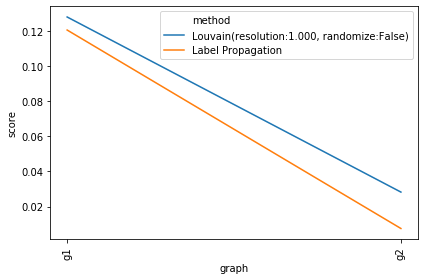

In [6]:
from cdlib import NodeClustering
g1 = nx.algorithms.community.LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = nx.algorithms.community.LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)
names = ["g1", "g2"]
graphs = [g1, g2]
references = []
for g in graphs:
    references.append(NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, graph=g, method_name="reference"))
algos = [algorithms.crisp_partition.louvain, algorithms.crisp_partition.label_propagation]
viz.plot_scoring(graphs, references, names, algos, scoring=evaluation.adjusted_mutual_information, nbRuns=2)

In [ ]:
viz.plot_sim_matrix([coms,coms2],evaluation.adjusted_mutual_information)

In [ ]:
graph.get_edge_data('833631744892997632', '3294535848')